# Machina Labs Assignment 🔧✨
### Author: Kian Zohoury
### Los Angeles, CA
### kzohoury@utexas.edu
### 310-508-1617


## I. Introduction

In this notebook, I present my completed work for the take-home assigment. I decided to fully contain my code in this notebook, because I believe it allows for my work to be more visible (not overlooked in .py files) and better showcases my step-by-step problem-solving abilities. However, in practice, I typically structure and modularize my code in the form of a package with several files like models.py, losses.py, train.py, etc.

Additionally, I admittedly would have probably benefited from using pre-trained, open-source models, but I felt that wouldn't really demonstrate my implementation skills. Of course, these days, fine-tuning pre-trained models are the way to go, and something I always do myself for vision/language tasks; however, for point cloud data specifically, I didn't really find any open-source models that I could easily adapt in the short amount of time I had for this project, especially for the generative, diffusion-based modeling task.    

## Problem Understanding
TODO: Discuss issues like incomplete data, noise, and limited defective part data. Justify model selection for reconstruction, denoising, and synthetic data generation.


## Setup

Before you begin, please pay attention to your version of **PyTorch** and **CUDA**. One of the required libraries in particular (NVIDIA's **kaolin**) relies on the exact versions you have on your machine. If you do not have CUDA, you will not be able to run any model training, which is fine if you are just looking to read my code and possibly run inference.

In [1]:
import itertools
import json
import os
import time

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List, Tuple

from plotly.subplots import make_subplots
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# check torch and cuda versions
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.0+cu121
CUDA version: 12.1


If using Google Colab as of October 2024, simply run the following cell:

In [2]:
!pip install kaolin==0.16.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html

Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.16.2-py3-none-any.whl size=27300 sha256=94d9d2fd2f7fa03e02fa192d9fe624beb9dbda79230619ddc0f87faa8330103b
  Stored in directory: /root/.cache/pip/wheels/4a/95/a2/2ee16c602170b0601ebeddbf06597868f09b7dbb0495ae99c4
Successfully built pygltflib


In [286]:
# import chamfer distance
from kaolin.metrics.pointcloud import chamfer_distance

Otherwise, please see if there is a version that you can download that matches your specs here: https://kaolin.readthedocs.io/en/latest/notes/installation.html

For this assignment, I primarily developed on Colab and used Lambda Cloud for distributed training, which had a later version of CUDA (12.4). The following were installed for my setup:

In [ ]:
# !pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124
# !pip install kaolin==0.16.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu124.html

Lastly, these are the remaining packages which are necessary to install. The only library which may give you trouble is Huggingface's **transformers**, but it should be fine if you're using a recent/stable PyTorch version.

In [ ]:
!pip install transformers
!pip install -U open3d
!pip install -U POT
!pip install trimesh
!pip install plotly
!pip install -U nbformat
!pip install huggingface_hub
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 14.6 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/

## Task I: Point Cloud Denoising & Completion

As outlined in the Problem Understanding section...

### Dataset

The dataset I selected to train models for both tasks is **ShapeNetCore**, which is a subset of ShapeNet. It contains 16 popular classes of objects as point clouds. There are a few other datasets I could've used, but ultimately decided on ShapeNetCore due to pragmatism -- I was able to download it instantly from Kaggle, while the full ShapeNet and ModelNet40 required submitting email requests to download, and I needed to get to work quickly. However, I still believe the models I've trained on this dataset could easily be transferred to real-world data scanned from metal parts, as it has a reasonably diverse range of object geometries.

To download the dataset, run the following cells:

In [13]:
from huggingface_hub import hf_hub_download

# download shapenetcore from my huggingface account
hf_hub_download(
    repo_id="kianzohoury/shapenetcore",
    filename="archive.zip",
    repo_type="dataset",
    local_dir="./"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


archive.zip:   0%|          | 0.00/450M [00:00<?, ?B/s]

'archive.zip'

In [14]:
# extract the data
!unzip -q archive.zip

In [15]:
# set as the root dataset directory for accessing train/test/val splits
data_dir = "Shapenetcore_benchmark"

#### **Dataset Preparation**

In order to load and work with the point cloud data as PyTorch tensors, I created the `NoisyShapeNetCore` Dataset class, which was designed for loading examples from ShapeNetCore containing pairs of the form $(x, y)$, with $x$ being a noisy version of the original/clean point cloud $y$.

In order to accomplish this, I did the following:
* read `.json` metadata files containing the class labels and locations of their `.npy` files,
* converted `.npy` files to numpy arrays and changed point clouds from `XZY` to `XYZ` format (this was more of a convenience for plotting),
* applied several **pre-processing** and **data augmentation** steps for the denoising task, which I will describe next,
* and lastly converted all arrays into PyTorch tensors for training

#### **Pre-Processing**

Pre-processing is extremely crucial in most deep learning problems. Fortunately, since the point clouds from ShapeNet are already clean, the only pre-processing I had to do for them is **normalization** and **down-sampling**, due to the point clouds not being standardized when it comes to scale, nor in the density/number of points.

##### Normalization
The reason it's crucial for each point cloud to fit within the same scale is because at test time, if a model recieves data on a different scale, it may generalize very poorly, so it's something we need to always think about. More importantly, when adding perturbations like noise for the denoising task, it's imperative that the randomly generated noise is also on the same scale, otherwise you get very weird looking point clouds (which I encountered before normalization).

Below is a function that allows each point cloud to fit within the unit sphere (i.e. centered about the origin $\vec 0$ with a maximum vector norm $||x||_2 = 1$). For each point $x$, we normalize as follows:

1. compute the mean of the point cloud: $\mu_{x} = \frac{1}{n}\sum_i^n x_i$
2. compute the max norm of the point cloud: $x_{norm}$ = $\max_i ||x_i||_2$
3. compute the normalized point cloud
$\bar x = (x - \mu_x) / x_{norm}$

In [16]:
def normalize_point_cloud(point_cloud: np.ndarray) -> np.ndarray:
    """Normalizes (shifts + scales) the point cloud."""

    # find center (mean) of point cloud
    mu = np.mean(point_cloud, axis=0)

    # find largest vector norm
    max_norm = np.max(np.linalg.norm(point_cloud, axis=1))

    # shift to be centered around origin and scale
    point_cloud_normalized = (point_cloud - mu) / max_norm
    return point_cloud_normalized

##### Down-sampling

Following data normalization, I down-sampled the point clouds to initially a maximum of 2048 points, but later found 1024 to be easier to work with (due to computational constraints). This was done by simply uniformily random sampling indices of the point cloud array to remove from the whole point cloud. Note, this is not the same as scaling (e.g. scaling the 3D object described by the point cloud to be larger or smaller). This is done in the `__getitem__` function of `NoisyShapeNetCore`:

```python
# downsample to max_points if necessary
if num_points > self.max_points:
    # use uniform random sampling (quick & dirty)
    if self.downsampling_mode == "uniform":
        kept_indices = np.random.choice(
            num_points, size=self.max_points, replace=False
        )
        target_point_cloud = target_point_cloud[kept_indices]
```


#### **Data Augmentation**

There is a series of data augmentation steps I took in order to curate the dataset for denoising/point completion. I will describe each function and then show how they are combined to generate noisy point clouds for training and evaluation on ShapeNetCore.

##### Adding Noise
The first agumentation is to randomly sample a noise vector from a normal distribution $\mathcal{N}(0, 1)$. The reasoning behind sampling noise from a Gaussian instead of a uniform distribution, is because it is *probably* (though I'm not certain on this) more realistic to how sensors receive noisy signals; however, other techniques of adding noise would likely also work pretty well and generate differently capable denoising models. The amount of noise that is added is controlled by a parameter $\epsilon$, which is the standard deviation of the Gaussian, but also specifically translates to a ratio of the norm (i.e. $\epsilon=0.01 = 1\%$ of the norm as a distance). Also, it's important to note that randomly sampling prevents the model from fitting to certain noise patterns, which is definitely not what we want our model to learn to solve. Increasing the strength of $\epsilon$ helps to also strengthen the model's denoising ability/robustness, but it should also be obvious that adding too much noise makes it very hard for a model to perform well, as the inputs start to become noise themselves, and may not even reflect the data seen in practice.

The process is as follows. For a given target point cloud $y$, we generate a noisy point cloud $x$:

$$x = y + v_{noise}$$

where $v_{noise} \sim \mathcal{N}(0, \epsilon)$. Note that all these vectors live in the same space (i.e. $\mathbb{R}^3$).

In [17]:
def add_noise(point_cloud: np.ndarray, amount: float = 1e-2) -> np.ndarray:
    """Randomly perturbs clean point cloud with noise."""
    # random_noise = np.random.normal(0, amount, size=point_cloud.shape)

    # try uniform noise instead
    random_noise = np.random.uniform(0, amount, size=point_cloud.shape)
    return point_cloud + random_noise

##### Removing Points
The second augmentation is to randomly remove points, similar to the down-sampling process described above. However, we do this specifically for the point completion task. The ratio $r \in [0, 1)$ controls the number of points to randomly remove from the point cloud, and so we can, for example, choose $r=0.25$, which will drop $25\%$ of the points, giving us an incomplete point cloud containing the remaining $75\%$ of the points.

In [18]:
def remove_points(point_cloud: np.ndarray, amount: float = 0.25) -> np.ndarray:
    """Randomly removes a percentage of points in the point cloud."""
    num_points = point_cloud.shape[0]
    num_to_keep = int(num_points * (1 - amount))
    kept_indices = np.random.choice(
        num_points, size=num_to_keep, replace=False
    )
    point_cloud = point_cloud[kept_indices]
    return point_cloud

In hindsight, a possible improvement I would've made was to use a spacially-aware point removal scheme. If I had more time and thought of this earlier, I would've used something like the k nearest neighbors (k-NN) algorithm to find a cluster of points and remove an entire region, instead of uniformly removing points. I believe this would help in cases where the laser scanning process was interrupted and a whole region of point clouds went missing.

##### On-The-Fly Data Augmentation
Similar to other works [], I used *on-the-fly* data augmentation for sampling noisy point clouds. Dynamically augmenting the point clouds ensures that the model never fits to certain noise patterns, which is a real possibility for large transformer-based models. It could be very easy to memorize how to denoise a given point cloud, if it always is present with the same noise pattern. So this type of data "sampling", if you will, ensures robustness and generalizability of the denoising model, since it will always see a slightly different noise pattern for each point cloud.

More specifcially, during a given training iteration, each point cloud $x_i$ will receieve a random transformation while the ground truth point cloud will remain clean. So for any given training epoch (one pass over the full batch of the training set), the noisy version of a point cloud is never identical. To accomplish this, I defined a `RandomTransform` class and had to ensure the seeds were set correctly for data loading, which I will describe in the training section.

Essentially, when called `RandomTransform` augments a point cloud, by first removing points according to the ratio $r$, and then adding noise according to $\epsilon$. However, the augmentations are done probabilistically, with a probability of applying both transformations as $\text{Pr}(\text{both})$. If only one augmentation is applied, the functions `remove_points()` and `add_noise()` have equal probability of being called.

In short, with $\text{Pr}(\text{both})=0.5$, roughly $50\%$ of the point clouds will receieve both augmentations, which means that $\text{Pr}(\text{add noise}) = \text{Pr}(\text{remove points}) = 0.25$. The `RandomTransform` class is very convenient, as it allows us to generate a specific kind of data distribution for each model we wish to train.


In [19]:
class RandomTransform:
    """Transformation that applies data augmentation for point completion/denoising tasks.

    Args:
        removal_amount: Percentage of points to remove.
            Default: 0.25.
        noise_amount: Additive scaling factor for Gaussian noise.
            Default: 0.01.
        prob_both: Probability of applying both transformations (noise & removal)
            Default: 0.5.
    """
    def __init__(
        self,
        removal_amount: float = 0.25,
        noise_amount: float = 1e-2,
        prob_both: float = 0.5,
    ) -> None:
        self.removal_amount = removal_amount
        self.noise_amount = noise_amount
        self.prob_both = prob_both

    def __call__(self, point_cloud: np.ndarray) -> Tuple:
        """Applies transformations to point cloud."""
        is_removed = is_noisy = False
        p = np.random.rand()
        # apply both transformation
        if p < self.prob_both:
            point_cloud = remove_points(point_cloud, self.removal_amount)
            point_cloud = add_noise(point_cloud, self.noise_amount)
            is_removed = is_noisy = True
        else:
            p = np.random.rand()
            # apply only one transformation
            if p < 0.5:
                point_cloud = add_noise(point_cloud, self.noise_amount)
                is_noisy = True
            else:
                point_cloud = remove_points(point_cloud, self.removal_amount)
                is_removed = True

        # also return a categorical label for the transformation
        # 0: identity, 1: is_removed, 2: is_noisy, 3: both
        if is_removed and is_noisy:
            transform_type = 3
        elif is_noisy:
            transform_type = 2
        elif is_removed:
            transform_type = 1
        else:
            transform_type = 0
        return transform_type, point_cloud

One additional thing to note is that once points are removed from a point cloud, you will point clouds of different sizes (i.e. number of points). The PyTorch `DataLoader` will have issues with this, since it expects each example in the batch to have the same shape. Moreover, similar to language tasks where sentences can be of different lengths, we need to zero-pad the point clouds. I defined a very simple function `add_padding()`, which appends zero vectors to the point cloud. On the surface, it may seem detrimental to the denoising task, but as I will describe shortly, we can bypass our denoising model from learning features associated with these redundant padding vectors via masking.



In [20]:
def add_padding(point_cloud: np.ndarray, max_points: int = 2048):
    """Adds zero-padding aka zero vectors according to the desired size."""
    num_pad = max_points - point_cloud.shape[0]
    padding = np.zeros((num_pad, 3))
    padded_point_cloud = np.vstack([point_cloud, padding])
    return padded_point_cloud

Thus, now that we've defined (mostly) everything related to data augmentations, below is the actual `NoisyShapeNetCore` class:

In [292]:
class NoisyShapeNetCore(Dataset):
    """ShapeNetCore dataset with applied augmentions for denoising & point completion.

    Args:
        root: Root directory of the dataset path.
        split: Dataset split (i.e. train, val, test).
            Default: "train".
        max_points: Max size of a point cloud.
            Default: 2048.
        downsampling_mode: Method of downsampling point clouds.
            Default: "uniform".
        input_transform: Transformation to apply to input point clouds.
            Default: None.
    """
    def __init__(
        self,
        root: str = data_dir,
        split: str = "train",
        max_points: int = 2048,
        downsampling_mode: str = "uniform",
        input_transform = None
    ) -> None:
        super(NoisyShapeNetCore, self).__init__()
        self.root_dir = root
        self.split = split
        self.max_points = max_points
        self.downsampling_mode = downsampling_mode
        self.input_transform = input_transform
        self.metadata = []

        # load metadata file
        with open(f"./{self.root_dir}/{self.split}_split.json", mode="r") as f:
            self.metadata = json.load(f)

        # map class labels to dataset indices
        self.class_label_to_idx = defaultdict(list)
        for idx in range(len(self.metadata)):
            class_label = self.metadata[idx][1]
            self.class_label_to_idx[class_label].append(idx)

    def __len__(self) -> int:
        """Returns length of dataset."""
        return len(self.metadata)

    def __getitem__(self, idx) -> Tuple:
        """Retrieves an example from the dataset.

        Specifically, it returns a tuple containing the class index,
        string label, transformation type, followed by the noisy (x) and
        clean (y) point cloud tensors.
        """
        class_idx, class_label, npy_path = self.metadata[idx]
        # load point cloud as numpy array
        target_point_cloud = np.load(Path(self.root_dir, npy_path))

        # swap coordinate positions because they come as xzy
        target_point_cloud = target_point_cloud[:, [0, 2, 1]]
        num_points = target_point_cloud.shape[0]

        # normalize point cloud
        target_point_cloud = normalize_point_cloud(target_point_cloud)

        # downsample to max_points if necessary
        if num_points > self.max_points:
            # use uniform random sampling (quick & dirty)
            if self.downsampling_mode == "uniform":
                kept_indices = np.random.choice(
                    num_points, size=self.max_points, replace=False
                )
                target_point_cloud = target_point_cloud[kept_indices]
            # could be used for different down-sampling techniques,
            # like spacially-aware ones that remove specific clusters
            # of points
            else:
                pass

        # apply transformation
        if self.input_transform is not None:
            transform_type, noisy_point_cloud = self.input_transform(
                target_point_cloud.copy() # copying to be extra careful
            )
        else:
            noisy_point_cloud = target_point_cloud.copy()
            transform_type = 0

        # zero-pad point clouds with zero vectors if necessary
        if noisy_point_cloud.shape[0] < self.max_points:
            noisy_point_cloud = add_padding(
                point_cloud=noisy_point_cloud, max_points=self.max_points
            )
        if target_point_cloud.shape[0] < self.max_points:
            target_point_cloud = add_padding(
                point_cloud=target_point_cloud, max_points=self.max_points
            )

        # convert to tensors
        noisy_point_cloud = torch.tensor(noisy_point_cloud, dtype=torch.float32)
        target_point_cloud = torch.tensor(target_point_cloud, dtype=torch.float32)
        return class_idx, class_label, transform_type, noisy_point_cloud, target_point_cloud

##### Optional: Rotations

Initially, I had also used **rotations** to augment the point clouds. In theory, this should also help increase the denoising model's robustness to objects in different spatial orientations. Without going into exact details, I randomly sampled an angle $a \in [0, 2\pi]$ for each rotation along the $x$-axis, $y$-axis, and $z$-axis. The corresponding rotation matrices were left multiplied in the following order:

$$\mathrm{M_{rot}} = \mathrm{R_{z}}\mathrm{R_{y}}\mathrm{R_{x}}$$

and then right multiplied to rotate a point cloud:

$$x_{rot} = x\mathrm{M^{T}}$$

Note that we have to transpose the $3 \times 3$ rotation matrix because it assumes column vector orientation, but we're dealing with point clouds that contain row vectors.

However, during training, I found this form of augmentation to seriously hinder convergence and also cause the model to generate point clouds with specific axes flipped. This could certainly be due to a bug in my implementation of the rotational matrices, but I've also provided the code for that below:

In [22]:
def rotate_batch(batch: torch.Tensor) -> torch.Tensor:
    """Applies a random (x, y, z) rotation to entire point clouds."""
    device = batch[-1].device
    # randomly sample angles
    a1, a2, a3 = torch.tensor(
        2 * np.pi * np.random.rand(3), dtype=torch.float32, device=device
    )

    # x-axis rotation
    rot_x = torch.tensor([
        [1, 0, 0],
        [0, torch.cos(a1), -torch.sin(a1)],
        [0, torch.sin(a1), torch.cos(a1)]
    ], device=device)

    # y-axis rotation
    rot_y = torch.tensor([
        [torch.cos(a2), 0, torch.sin(a2)],
        [0, 1, 0],
        [-torch.sin(a2), 0, torch.cos(a2)]
    ], device=device)

    # z-axis rotation
    rot_z = torch.tensor([
        [torch.cos(a3), -torch.sin(a3), 0],
        [torch.sin(a3), torch.cos(a3), 0],
        [0, 0, 1]
    ], device=device)

    # generate full rotational matrix
    rot_matrix = torch.mm(rot_z, torch.mm(rot_y, rot_x))

    # unpack batch
    class_idx, class_label, transform_type, x, y_true = batch

    # rotate point clouds
    x, y_true = x.matmul(rot_matrix.T), y_true.matmul(rot_matrix.T)
    return class_idx, class_label, transform_type, x, y_true

#### **Visualizing the Dataset**
Now that I've defined all the necessary classes and functions for data preparation, let's actually take a look at and compare the original point clouds from ShapeNetCore to their corresponding noisy versions the denoising model would see as input.

In [23]:
# create an input transform with 50% points removed and 2% noise
input_transform = RandomTransform(removal_amount=0.5, noise_amount=0.02)

# create the dataset (use 2048 for better visualization, but 1024 when training)
train_data = NoisyShapeNetCore(
    split="train",
    max_points=2048,
    input_transform=input_transform
)

Let's also get the dataset indices of each of the 16 ShapeNetCore classes, so we can look at specific instances of each class.

In [24]:
# display the 16 main classes
print(train_data.class_label_to_idx.keys())

dict_keys(['Knife', 'Airplane', 'Laptop', 'Table', 'Chair', 'Lamp', 'Guitar', 'Earphone', 'Rocket', 'Mug', 'Car', 'Pistol', 'Bag', 'Motorbike', 'Cap', 'Skateboard'])


Also, as an aside, we can look at the distribution of object classes. Even though we're not doing object detection/classification, it *could* be an important conideration if the types of geometries that are relevant to how the denoising model will be deployed in practice, are not really represented in this training set.

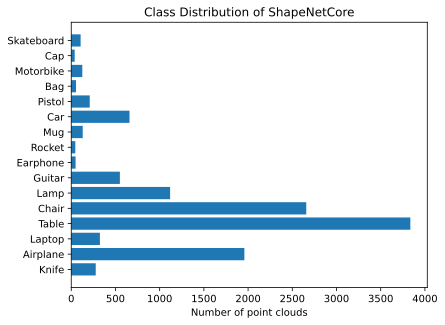

In [25]:
%config InlineBackend.figure_format = 'svg'

class_counts = [len(indices) for (class_label, indices) in train_data.class_label_to_idx.items()]

plt.barh(y=list(train_data.class_label_to_idx.keys()), width=class_counts)
plt.title("Class Distribution of ShapeNetCore")
plt.xlabel("Number of point clouds")
plt.show()

So in theory, our model will do best on tables, chairs, and airplanes, which could have pretty complex/varied geometries, a property of the dataset we typically want. It's the variations in geometries *within* each class which will help the models become more robust, especially for point completion. However, for classes with fewer examples (i.e.. caps, rockets, earphone), it's unreasonable to assume the model to have similar performance as it will when processing instances that it knows well (more common classes).

Below, let's visualize comparisons between clean and noisy point clouds. First, set the class you want to visualize:

In [26]:
# set class you would like to visualize
class_to_visualize = "Airplane"

Next, I defined a simple function for visualizing the point clouds pairs using **plotly**:

In [45]:
def visualize_point_cloud_comparison(
    dataset: NoisyShapeNetCore,
    class_label: str = class_to_visualize,
    model: nn.Module = None,
    title: str = ""
    ) -> None:
    """Compares a clean point cloud (y) against its augmented/noisy version (x).

    Optionally, plots the comparison with a model's estimate f(x).
    """

    # sample random point cloud belonging to the class
    idx = np.random.choice(dataset.class_label_to_idx[class_label])
    transformation_type, noisy_point_cloud, target_point_cloud = dataset[idx][-3:]
    if dataset.input_transform:
        ratio_removed = dataset.input_transform.removal_amount
        noise_amount = dataset.input_transform.noise_amount
    else:
        ratio_removed = noise_amount = 0

    # compute Chamfer Distance
    if not title and torch.cuda.is_available:
        chamf_dist = chamfer_distance(
            p1=noisy_point_cloud.unsqueeze(0).cuda(),
            p2=target_point_cloud.unsqueeze(0).cuda()
        )
        title = f"Chamfer Distance: {round(chamf_dist.item(), 6)}"

    if transformation_type == 1:
        noisy_title = f"{int(ratio_removed * 100)}% points missing"
    elif transformation_type == 2:
        noisy_title = f"noise={noise_amount}"
    else:
        noisy_title = f"{int(ratio_removed * 100)}% points missing" + \
            ", " + f"noise amount = {noise_amount}"

    titles = ["Original", noisy_title]
    titles = titles + (["Reconstruction"] if model is not None else [])
    # make plotly subplots
    fig = make_subplots(
        rows=1, cols=2 if model is None else 3,
        specs=[[{'type': 'scatter3d'}] * (2 if model is None else 3)],
        subplot_titles=tuple(titles),
        horizontal_spacing=0.001
    )

    # create the scatter plots
    target_scatter_plot = go.Scatter3d(
        x=target_point_cloud[:, 0],
        y=target_point_cloud[:, 1],
        z=target_point_cloud[:, 2],
        mode='markers',
        marker=dict(size=2.5)
    )
    noisy_scatter_plot = go.Scatter3d(
        x=noisy_point_cloud[:, 0],
        y=noisy_point_cloud[:, 1],
        z=noisy_point_cloud[:, 2],
        mode='markers',
        marker=dict(size=2.5)
    )

    # run model inference
    if model is not None:
        device = list(model.parameters())[0].device
        reconstruction = model(
            noisy_point_cloud.unsqueeze(0).to(device)
        ).squeeze(0).cpu().detach().numpy()
        reconstruction_scatter_plot = go.Scatter3d(
            x=reconstruction[:, 0],
            y=reconstruction[:, 1],
            z=reconstruction[:, 2],
            mode='markers',
            marker=dict(size=2.5)
        )
    else:
        reconstruction_scatter_plot = None


    # plot them
    fig.add_trace(target_scatter_plot, row=1, col=1)
    fig.add_trace(noisy_scatter_plot, row=1, col=2)
    if reconstruction_scatter_plot is not None:
        fig.add_trace(reconstruction_scatter_plot, row=1, col=3)

    # hides axes for cleaner look
    fig.update_layout(
        scene1=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        scene2=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        scene3=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        title_text=title, title_x=0.5,
        autosize=True,
    )
    fig.show()

Now, just run the following cell to visualize. You can toggle different instances of a class by re-running the function, since the index is randomized. By toggling, you will also see that each noisy point cloud will have either noise added, points removed, or both. Additionally, a distance metric called the *Chamfer Distance* (which will be defined in the training section) is used to measure the similarity between the two point clouds (with a lower distance being better).

In [28]:
visualize_point_cloud_comparison(
    dataset=train_data,
    class_label=class_to_visualize
)

### Define Model Architecture

The architecture that I chose leverages transformers as they are highly adaptable beyond natural language tasks, including vision and geometric data such as the types of data (i.e. point clouds) we're dealing with. The idea behind using transformers is two-fold: (1) they are extremely powerful and easy to scale, as we can increase the depth of the model with a single line of code in PyTorch; (2) and more importantly, they utilize self-attention [], which is a highly important concept that allows for deep learning models to learn long-range dependencies and rich contextual information. Self-attention is defined as:

$$\text{Softmax}(\frac{\text{Q}\text{K}^{T}}{\sqrt{d_{k}}})\text{V}$$

where $\text{K} \in \mathbb{R}^{d_k \times d_{model}}$, $\text{Q} \in \mathbb{R}^{d_k \times d_{model}}$, $\text{V} \in \mathbb{R}^{d_v \times d_{model}}$ are learnable model parameters that generate the attention scores for each self-attention mechanism.

More specifically, I designed an encoder-decoder model that uses...


* explain why we can't use regular positional embeddings (non-discrete values)
* explain why causal mask is not required
* explain why purely encoder or decoder were not chosen
* explain how this is sort of like seq2seq, T5, etc. and why that allows us to generate more points as needed by the decoder with next token prediction

In [29]:
class SpatialEmbedding(nn.Module):
    """Relative positional embedding to enhance spatial/contextual awareness."""
    def __init__(self, d_model: int = 64):
        super(SpatialEmbedding, self).__init__()
        self.d_model = d_model
        self.positional_embedding = nn.Linear(3, d_model)
        self.distance_embedding = nn.Linear(1, d_model)
        nn.init.kaiming_uniform_(self.positional_embedding.weight)
        nn.init.kaiming_uniform_(self.distance_embedding.weight)

    def forward(self, point_cloud: torch.Tensor) -> torch.Tensor:
        # compute relative positions between each point
        relative_positions = point_cloud[:, :, None, :] - point_cloud[:, None, :, :]

        # calculate pair-wise distances
        relative_distances = torch.sqrt(
            (relative_positions ** 2).sum(dim=-1, keepdim=True)
        )

        # project onto positional and distance embedding spaces
        positional_embedding = self.positional_embedding(relative_positions)
        distance_embedding = self.distance_embedding(relative_distances)

        # sum together and collapse extra dimension by max pooling
        spatial_embedding = positional_embedding + distance_embedding
        spatial_embedding = spatial_embedding.max(dim=2)[0]
        return spatial_embedding

#### Step 1: Define the **Point Cloud Encoder** (PCEncoder)

In [30]:
class PCEncoder(nn.Module):
    """Encoder module for extracting local contextual/geometric features"""
    def __init__(
        self,
        num_layers: int = 4,
        num_heads: int = 8,
        d_model: int = 64,
    ) -> None:
        super(PCEncoder, self).__init__()
        # define individual encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, batch_first=True, dropout=0
        )

        # define encoder (enc x num_layers)
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer, num_layers=num_layers
        )

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor) -> List[torch.Tensor]:
        """Forward pass returns encoded features 1,...,num_layers."""
        latent_features = []
        for encoder_layer in self.encoder.layers:
            x = encoder_layer(x, src_key_padding_mask=padding_mask)
            latent_features.append(x)
        return latent_features

#### Step 2: Define the **Point Cloud Decoder** (PCDecoder)

In [31]:
class PCDecoderLayer(nn.Module):
    """Decoder layer that performs multi-head cross-attention from encoded
    features to drive denoising/completion task."""

    def __init__(
        self,
        num_heads: int = 8,
        d_model: int = 64,
    ) -> None:
        super(PCDecoderLayer, self).__init__()
        # define standard self-attention mechanism
        self.self_attention = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads, batch_first=True
        )

        # layer normalization 1
        self.layer_norm_1 = nn.LayerNorm(d_model)

        # define cross-attention mechanism (symmetric structure to self-attention)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads, batch_first=True
        )

        # layer normalization 2
        self.layer_norm_2 = nn.LayerNorm(d_model)

        # define affine layers (final feed-forward layers)
        self.linear = nn.Sequential(
            nn.Linear(in_features=d_model, out_features=d_model * 4),
            nn.ReLU(),
            nn.Linear(in_features=d_model * 4, out_features=d_model)
        )

        # layer normalization 3
        self.layer_norm_3 = nn.LayerNorm(d_model)

    def forward(
        self,
        x: torch.Tensor,
        latent_features: torch.Tensor,
        padding_mask: torch.Tensor
    ) -> torch.Tensor:
        """Forward pass returns decoded features."""

        # compute self-attention scores
        self_attention, _ = self.self_attention(
            query=x, key=x, value=x, key_padding_mask=padding_mask
        )

        # add skip connection -> normalize
        x = self.layer_norm_1(x + self_attention)

        # compute cross-attention scores
        cross_attention, _ = self.cross_attention(
            query=x,
            key=latent_features,
            value=latent_features,
            key_padding_mask=padding_mask
        )

        # add skip connection -> normalize
        x = self.layer_norm_2(x + cross_attention)

        # feed-forward -> add skip connection -> normalize
        output_features = self.layer_norm_3(self.linear(x) + x)
        return output_features

In [32]:
class PCDecoder(nn.Module):
    """Decoder module for generating final point cloud estimates."""
    def __init__(
        self,
        num_layers: int = 4,
        num_heads: int = 8,
        d_model: int = 64,
    ) -> None:
        super(PCDecoder, self).__init__()
        # define cross-attention decoder layers
        self.decoder_layers = nn.ModuleList()
        for i in range(num_layers):
            self.decoder_layers.append(
                PCDecoderLayer(num_heads=num_heads, d_model=d_model)
            )

    def forward(
        self,
        x: torch.Tensor,
        latent_features: List[torch.Tensor],
        padding_mask: torch.Tensor
    ) -> torch.Tensor:
        """Forward pass returns final estimated point cloud given input point
        cloud and learned latent features via the encoder."""
        # calculate mask to ignore zero vectors
        padding_mask = torch.all(x == 0, dim=-1)
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer(x, latent_features[i], padding_mask=padding_mask)
        return x

#### Step 3: Define the **Encoder-Decoder** Model (PCDenoiser)

Finally, we put it all together...

In [307]:
class PCDenoiser(nn.Module):
    """Dual-task transformer-based architecture designed for point cloud
    denoising & completion. Number of points to estimate will be fixed (same as input).

    Args:
        num_layers: Number of layers for encoder/decoder.
            Default: 4.
        num_heads: Number of attention heads per multi-head attention mechanism.
            Default: 8.
        d_model: Embedding/K, Q, V dimensionality.
            Default: 64.
        output_size:
    """
    def __init__(
        self,
        num_layers: int = 4,
        num_heads: int = 8,
        d_model: int = 64,
        use_pos_embeddings: bool = True
    ):
        super(PCDenoiser, self).__init__()
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.use_pos_embeddings = use_pos_embeddings

        # create positional embeddings
        if self.use_pos_embeddings:
            self.spatial_embedding = SpatialEmbedding(d_model=d_model)
        # standard learnable embeddings
        self.input_projection = nn.Linear(in_features=3, out_features=d_model)
        nn.init.kaiming_uniform_(self.input_projection.weight)

        # define encoder module
        self.encoder = PCEncoder(
            num_layers=num_layers, num_heads=num_heads, d_model=d_model
        )

        # define decoder module
        self.decoder = PCDecoder(
            num_layers=num_layers, num_heads=num_heads, d_model=d_model
        )

        # final feed-forward layers
        self.output_projection = nn.Sequential(
            nn.Linear(in_features=d_model, out_features=d_model // 2),
            nn.LeakyReLU(),
            nn.Linear(in_features=d_model // 2, out_features=d_model // 4),
            nn.LeakyReLU(),
            nn.Linear(in_features=d_model // 4, out_features=3)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns estimated point cloud."""
        # calculate padding mask to ignore zero vectors
        padding_mask = torch.all(x == 0, dim=-1)

        # project to higher dimensional feature space
        point_cloud_embeddings = self.input_projection(x)
        if self.use_pos_embeddings:
            point_cloud_embeddings += self.spatial_embedding(x)

        # pass through encoder to generate list of latent features
        latent_features = self.encoder(
            point_cloud_embeddings, padding_mask=padding_mask
        )

        # pass input and latent features through decoder
        # output = self.decoder(
        #     x=point_cloud_embeddings,
        #     latent_features=latent_features,
        #     padding_mask=padding_mask
        # )
        output = latent_features[-1]

        # project points back to cartesian aka (x, y, z) space
        point_cloud = self.output_projection(output)
        return point_cloud

### Training PCDenoiser
Now that the model architecture is outlined, we have to solve both tasks of (1) denoising point clouds and (2) completing point clouds with randomly missing points. While these can be thought of as distinct tasks, where one model could learn to denoise (e.g. denoising autoencoder) and another model solely for point completion, for simplicity, I combined both tasks. In some sense, missing points is a form of "noise" as it results in a lossy data point that increases the uncertainty of a classification model designed to classify a point cloud.

Furthermore, before training, we need to determine an appropriate loss function that is not only well-suited for this task, but also differentiable. This is key, as it enables us to optimize our model using gradient descent, which requires differentiability to calculate gradients and run backpropagation.

#### **Loss Function**
We can unify both tasks with a single loss function, namely, **Chamfer Distance**. It is defined as:

$$L_{CD}(P_1, P_2) = \frac{1}{|P_1|}\sum_{p \in P_1} \min_{p' \in P_2} ||p - p'||_{2}^2 + \frac{1}{|P_2|}\sum_{p' \in P_2} \min_{p \in P_1} ||p' - p||_{2}^2$$

Note that I used the Euclidean distance formulation here (but $||\cdot||_{1}$ norm is sometimes used). Given two point clouds $P_1 \in \mathbb{R}^3$, $P_2 \in \mathbb{R}^3$, it essentially measures the distance between them. Specifically, for every point in $P_1$, it measures the distance between the nearest point in $P_2$, and vice versa. One thing to consider is that efficiently implementing this loss requires an efficient method of computing nearest neighbors (e.g. using K-D trees). In order to maximize efficiency (training speed), I've shamelessly decided to utilize NVIDIA's kaolin library, as their implementation uses special CUDA-related optimizations.

In [24]:
# lets calculate the Chamfer distance between a clean and noisy point cloud
if torch.cuda.is_available():
    example_clean_pc, example_noisy_pc = train_data[0][-2:]
    chamf_dist = chamfer_distance(
        p1=example_clean_pc.unsqueeze(0).cuda(),
        p2=example_noisy_pc.unsqueeze(0).cuda()
    )
    print(f"Chamfer Distance: {chamf_dist.item()}")

Chamfer Distance: 0.00034123845398426056


#### **Training Objective**
This is a supervised machine learning problem, where we have a training set $\mathcal{D}_{i}^{N} = \{(x_1, y_2),...,(x_N, y_N)\}$ with noisy input point clouds and their corresponding original ground truth point clouds. Our training objective is to find the optimal set of parameters $\theta$ of our model that minimizes the expected loss over the entire dataset, namely:

$$\theta^* = \arg\min_{\theta}\sum_{i}^{N}L(x_i, y_i, \theta)$$

where $$L(x_i, y_i, \theta) = L_{CD}(f_\theta(x_i), y_i)$$ and $f_\theta$ is our denoising model.

#### **Experimental Setup**
As mentioned in the data preparation section, I dynamically augmented the point clouds to ensure/mitigate the potential for the model to fit to certain noise patterns. I investigated two choices for both $\epsilon = 0.01, 0.02$ and $r=0, 0.5$, which resulted in 4 combinations (and therefore, denoising models):



| Model  | noise strength (%) | points removed (%) |
| :---------------- | :------: | :----: |
| pc_denoiser_1     |   1   | 0     |
| pc_denoiser_2     |   1   | 50   |
| pc_denoiser_3     |  2    | 0     |
| pc_denoiser_4     |  2    | 50   |
    

I also mentioned in that section my attempt to strengthen the rotational-invariance (robustness to objects presented in varying orientations) of the denoising model did not lead to great results during the initial training runs (possibly due to a bug/minor issue). Nevertheless, during each iteration, a point cloud was randomly rotated in $\mathbb{R}^3$ with $\text{Pr}(\text{rotate})=0.25$.

In [34]:
# four combinations representing the strength of point cloud augmentations
noise_amounts = [0.01, 0.02]
removal_amounts = [0, 0.5]
augmentation_combos = list(itertools.product(noise_amounts, removal_amounts))
for i in range(len(augmentation_combos)):
    print(f"Experiment {i + 1}: {augmentation_combos[i]}")

Experiment 1: (0.01, 0)
Experiment 2: (0.01, 0.5)
Experiment 3: (0.02, 0)
Experiment 4: (0.02, 0.5)


##### **Hyperparameters**
The hyperparameters for training the denoising models were chosen empirically based on initial training runs and GPU capacity. Note that they are fixed across all four experiments, due to simplicity and the time constraint for this assignment. However, in practice one should optimize the hyperparameters separately for each of these four models as the distribution of the training data will be slightly to significantly different based on how different or extreme the data augmentations are for each combination.

* learning rate: $1e-3$
* warmup ratio: $0.1$
* batch size: $8$ x number of GPUs
* max number of epochs: $300$
* max number of points per point cloud: $1024$
* number of encoder/decoder layers: $8$
* number of self-attention/cross-attention heads per layer: $8$
* embedding & K, Q, V vector dimension: $256$
* number of dataloader processes/workers: $8$

In [35]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# define hyper-parameters
lr = 1e-3
warmup_ratio = 0.1
batch_size = 16 * num_gpus or 1 # in case a GPU is not availabe
max_num_epochs = 300
max_points = 1024
num_layers = 8
num_heads = 8
d_model = 256
dropout = 0.1
num_workers = 8

# set this to None to train on full dataset
# set to a lower number for fewer training examples
max_batches = round((len(train_data) / batch_size) * 0.5)

Number of GPUs available: 1


#### **Optimization**
For optimization, I chose AdamW [] (with default parameters) as it's a powerful adaptive, momentum-based gradient descent optimization method that is typically very effective for training larger, transformer-based models. I also decided to use learning rate scheduling as it also (in my experience) improves training for transformer models. I used a linear schedule for the first 10% of training steps (10 epochs) to warmup the model and a cosine annealing schedule for the remanining 90% of training steps. I found that the warmups were essential for stable training in the initial stages, otherwise the models had trouble training/converging.

In [36]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

class LRScheduler:
    """Learning rate scheduler that applies linear scaling for warmup and decay after."""
    def __init__(
        self,
        optimizer: Any,
        step_size: int,
        total_steps: int,
        warmup_ratio: float = 0.1
    ):
        self.optimizer = optimizer
        self.step_size = step_size
        self.total_steps = total_steps
        self.warmup_steps = int(warmup_ratio * total_steps)
        self.num_steps = 0

        # define warmup scheduler
        self.warmup_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.warmup_steps,
            num_training_steps=self.total_steps
        )

        # define decay scheduler
        self.lr_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.total_steps - self.warmup_steps
        )

    def step(self):
        """Updates learning rate."""
        self.num_steps += self.step_size
        if self.num_steps <= self.warmup_steps:
            self.warmup_scheduler.step()
        else:
            self.lr_decay_scheduler.step()

#### **Cross Validation**

##### Deterministic Augmentations
During training, data augmentations happens on-the-fly, but the augmentations for the validation set needed to be fixed in order to achieve consistency with cross validation. By defining a `worker_init_fn()`, I was able to deterministically control how augmentations were made to data batches. This is because `worker_init_fn()` is called when each worker is spawned (in parallel), and so the global random state (defined by the numpy seed) can fix the sampling behavior that control the augmentations when the data loader fetches a batch of data using different workers.

In [37]:
def worker_init_fn(worker_id) -> None:
    """Custom initialization function that helps fix data augmentation behavior per worker."""
    seed = np.random.get_state()[1][0]
    np.random.seed(seed + worker_id)

I also wanted to maintain consistency for each denoising experiment (i.e. training run) while allowing the data augmentations to be different for each epoch. To do this, I stored a master seed, and then generated `max_num_epochs` number of seeds, each being set during a new training epoch. The reason I felt this was important, is because I didn't want the variance in model performance to depend on the randomness of the data augmentations across training runs, as they would technically be seeing and training on slightly different distributions of data.

In [38]:
# set master seed for reproducibility
np.random.seed(0)

# this allows each model to receive the same training augmentations
training_augmentation_seeds = np.random.randint(2, 2**32 - 1, size=max_num_epochs)

##### Early Stopping

For a given experiment (training run), model selection was driven using **early stopping** based on a validation criteria (i.e. average loss). For each epoch, the denoising model is evaluated on a validation set using the same loss function during training. After 10 epochs, we terminate training if validation performance stagnates. This is one way that we can prevent **overfitting**, since we can simply stop training once the model stops improving. In my training code, it looks like this:

```python
if val_loss < best_val_loss:
    best_val_loss = val_loss
    # reset early stopping counter
    count = 0

    # save best model
    torch.save(...)
    print("Best model saved.")
else:
    # increment early stopping counter
    count += 1
    if count == patience:
        # stop training
        print("Stopping training early.")
        break
```

##### Baseline Comparison
One insightful validation/evaluation strategy is to also compare these models against a baseline (no model, just the Chamfer Distance between each $x$ and $y$ in the test dataset), to see if the models are actually better/worth using. We will use this to monitor model training but also evaluate their final performance.

In [293]:
def get_baseline_chamfer_dist(dataloader: DataLoader, device: str) -> float:
    """Gets the baseline (total Chamfer Distance across the whole dataset."""
    total_chamf_dist_without_model = 0
    for example in dataloader:
        noisy_point_cloud, target_point_cloud = example[-2:]
        padding_mask = torch.all(target_point_cloud == 0, dim=-1)
        # batch_size, num_points = target_point_cloud.shape[:2]

        noisy_point_cloud = noisy_point_cloud[~padding_mask].unsqueeze(0)
        target_point_cloud = target_point_cloud[~padding_mask].unsqueeze(0)

        # new_batch_size = min(batch_size, noisy_point_cloud.shape[0] // num_points)
        # print(new_batch_size, noisy_point_cloud.shape)

        # noisy_point_cloud = noisy_point_cloud.view(new_batch_size, -1, 3)
        # target_point_cloud = target_point_cloud.view(new_batch_size, -1, 3)
        # print(noisy_point_cloud.shape)
        chamf_dist = chamfer_distance(
            p1=noisy_point_cloud.to(device),
            p2=target_point_cloud.to(device)
        )
        total_chamf_dist_without_model += chamf_dist.mean().item()
    mean_chamf_dist_without_model = total_chamf_dist_without_model / len(dataloader)
    return mean_chamf_dist_without_model

The final model and checkpoint file that would be ultimately saved was the one tied to the highest validation performance (lowest total $L_{CD}$ loss), not the one resulting after all 100 epochs of training was completed.

#### **Defining Training Code**
Below, I've defined the training loop that is run every epoch:

In [317]:
def chamfer_distance(p1, p2):
    """
    Computes Chamfer Distance between two point clouds.

    Arguments:
    pred -- (batch_size, num_points, 3), predicted point cloud
    target -- (batch_size, num_points, 3), ground truth point cloud

    Returns:
    distance -- scalar Chamfer Distance
    """
    # Compute pairwise distance between points in the predicted and target point clouds
    dist_pred_to_target = torch.cdist(p1, p2, p=2)  # Shape: (batch_size, num_points, num_points)
    dist_target_to_pred = torch.cdist(p1, p2, p=2)  # Shape: (batch_size, num_points, num_points)

    # Find the minimum distance from each point in pred to target (nearest neighbor distance)
    min_dist_pred_to_target = dist_pred_to_target.min(dim=2)[0]  # (batch_size, num_points)

    # Find the minimum distance from each point in target to pred
    min_dist_target_to_pred = dist_target_to_pred.min(dim=2)[0]  # (batch_size, num_points)

    # Compute the mean of the minimum distances
    loss = torch.mean(min_dist_pred_to_target) + torch.mean(min_dist_target_to_pred)

    return loss



In [358]:
def train_epoch(
    model: nn.Module,
    optimizer: Any,
    scheduler: Any,
    dataloader: DataLoader,
    max_batches = None
) -> float:
    """Trains model over the entire training set and returns the mean loss."""
    max_batches = len(dataloader) if max_batches is None else max_batches
    max_batches = min(len(dataloader), max_batches)
    device = list(model.parameters())[0].device
    total_loss = 0

    model.train()
    with tqdm(dataloader, total=max_batches) as tq:
        tq.set_description(f"train")
        for batch_idx, batch in enumerate(tq):

            # # apply rotation with prob=0.25
            # rot_prob = np.random.rand()
            # if rot_prob <= 0.25:
            #     batch = rotate_batch(batch)

            # unpack batch
            class_idx, class_label, transform_type, x, y_true = batch

            # push point clouds to gpu
            x, y_true = x.to(device), y_true.to(device)
            padding_mask = torch.all(x == 0, dim=-1)

            # run forward pass
            y_pred = model(x)

            # compute loss
            y_pred = y_pred[~padding_mask].unsqueeze(0)
            y_true = y_true[~padding_mask].unsqueeze(0)
            loss = 0.9 * chamfer_distance(p1=y_pred, p2=y_true).mean() + 0.1 * nn.functional.mse_loss(y_pred, y_true)
            # loss = nn.functional.mse_loss(y_pred, y_true)
            total_loss += loss.item()

            # backprop + update parameters + update lr
            loss.backward()
            optimizer.step()
            scheduler.step()

            # clear gradients
            optimizer.zero_grad()

            # display loss via logger
            mean_loss = total_loss / (batch_idx + 1)
            tq.set_postfix({"mean_loss": round(mean_loss, 7)})

            if batch_idx == max_batches:
                break
    mean_loss = total_loss / len(dataloader)
    return mean_loss

The validation loop is almost identical, but no updates are made to the model.

In [354]:
def validate_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    max_batches = None
) -> float:
    """Validates model over the entire validation set and returns the mean loss."""
    max_batches = len(dataloader) if max_batches is None else max_batches
    max_batches = min(len(dataloader), max_batches)
    device = list(model.parameters())[0].device
    total_loss = 0

    model.eval()
    with torch.no_grad():
        with tqdm(dataloader, total=max_batches) as tq:
            tq.set_description(f"valid")
            for batch_idx, batch in enumerate(tq):

                # # apply rotation with prob=0.25
                # rot_prob = np.random.rand()
                # if rot_prob <= 0.25:
                #     batch = rotate_batch(batch)

                # unpack batch
                class_idx, class_label, transform_type, x, y_true = batch

                # push point clouds to gpu
                x, y_true = x.to(device), y_true.to(device)
                padding_mask = torch.all(x == 0, dim=-1)

                # run forward pass
                y_pred = model(x)

                y_pred = y_pred[~padding_mask].unsqueeze(0)
                y_true = y_true[~padding_mask].unsqueeze(0)

                # compute loss
                loss = chamfer_distance(p1=y_pred, p2=y_true).mean()
                # loss = nn.functional.mse_loss(y_pred, y_true)
                total_loss += loss.item()

                # display loss via logger
                mean_loss = total_loss / (batch_idx + 1)
                tq.set_postfix({"mean_loss": round(mean_loss, 7)})

                if batch_idx == max_batches:
                    break
    mean_loss = total_loss / len(dataloader)
    return mean_loss

##### **Run Training**
Now that that both the training and validation loops are defined, we can finally begin training. If you would like to reproduce my results, please skip the following cell, but if you would like to simply test the functionality of my training code, I've defined smaller model and training hyperparameters below, and training should take no longer than ~7 minutes with a single NVIDIA A100 GPU.

In [328]:
lr = 1e-4
batch_size = 8
max_num_epochs = 200
max_points = 1024
num_layers = 4
num_heads = 8
d_model = 256
num_workers = 8
max_batches = 100

In [306]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, embed_size, num_points):
        super(SinusoidalPositionalEncoding, self).__init__()
        self.embed_size = embed_size

        # Create a positional encoding matrix
        pos = torch.arange(0, num_points, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe = torch.zeros(num_points, embed_size)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('positional_encoding', pe)

    def forward(self, x):
        # Add positional encoding to the input
        return x + self.positional_encoding[:x.size(1), :]

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, num_points, embed_size):
        super(LearnablePositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(num_points, embed_size))

    def forward(self, x):
        # Add learnable positional encodings to the input
        return x + self.positional_encoding[:x.size(1), :]


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_size, num_heads, forward_expansion):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(attn_output + x)  # Add & Norm

        # Feed-forward network
        forward_output = self.feed_forward(x)
        out = self.norm2(forward_output + x)  # Add & Norm

        return out

# Define the full transformer encoder for point cloud denoising
class PCDenoiser(nn.Module):
    def __init__(self, d_model, num_heads=8, num_layers=8, forward_expansion=4):
        super(PCDenoiser, self).__init__()
        self.embedding = nn.Linear(3, d_model)
        self.embedding_norm = nn.LayerNorm(d_model)
        # self.pos_embedding = SinusoidalPositionalEncoding(d_model, max_points)
        # self.pos_embedding = LearnablePositionalEncoding(max_points, d_model)
        self.pos_embedding = SpatialEmbedding(d_model=d_model)
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderBlock(d_model, num_heads, forward_expansion) for _ in range(num_layers)]
        )
        self.output_layer = nn.Linear(d_model, 3)  # Map back to (x, y, z)

    def forward(self, point_cloud):
        # Embed the (x, y, z) coordinates to a higher-dimensional space
        x = self.embedding(point_cloud)
        # x = self.embedding_norm(x)

        x += self.pos_embedding(point_cloud) # (batch_size, num_points, embed_size)

        # x = self.embedding(point_cloud)
        # x = x + self.pos_embedding(point_cloud) # (batch_size, num_points, embed_size)
        x = x.permute(1, 0, 2)  # Transpose for multi-head attention (required shape: seq_len, batch_size, embed_size)

        # Pass through each encoder layer
        for layer in self.encoder_layers:
            x = layer(x)

        x = x.permute(1, 0, 2)  # Transpose back to original shape (batch_size, num_points, embed_size)

        # Map the final embedding back to (x, y, z)
        denoised_points = self.output_layer(x)  # (batch_size, num_points, 3)

        return denoised_points

In [123]:
class PCDenoiser(nn.Module):
    def __init__(self, d_model, num_heads=8, num_layers=8, forward_expansion=4):
        super(PCDenoiser, self).__init__()
        self.input_projection = nn.Linear(3, d_model)
        self.fc1 = nn.Sequential(nn.Linear(d_model, d_model), nn.LeakyReLU(), nn.Linear(d_model, d_model))
        # self.fc2 = nn.Sequential(nn.Linear(d_model, d_model), nn.LeakyReLU(), nn.Linear(d_model, d_model))
        # self.fc3 = nn.Sequential(nn.Linear(d_model, d_model), nn.LeakyReLU(), nn.Linear(d_model, d_model))
        self.output_projection = nn.Linear(d_model, 3)
    def forward(self, x):
        # Project the input (x, y, z) into the embedding space
        x_copy = x
        x = self.input_projection(x)

        # First residual block
        residual = x  # Store the input to add as residual
        x = self.fc1(x)
        x = nn.functional.relu(x + residual)  # Add residual and apply ReLU

        # # Second residual block
        # residual = x  # Update the residual with the output of the first block
        # x = self.fc2(x)
        # x = nn.functional.relu(x + residual)  # Add residual and apply ReLU

        # # Third residual block
        # residual = x  # Update the residual with the output of the second block
        # x = self.fc3(x)
        # x = nn.functional.relu(x + residual)  # Add residual and apply ReLU

        # Project back to the original (x, y, z) space
        x = self.output_projection(x) + x_copy
        return x


# class PCDenoiser(nn.Module):
#     def __init__(self, d_model, num_heads=8, num_layers=8, forward_expansion=4):
#         super(PCDenoiser, self).__init__()
#         self.input_projection = nn.Linear(3, 3)
#         self.output_projection = nn.Linear(3, 3)
#     def forward(self, x):
#         res = x
#         x = self.input_projection(x)
#         x = self.output_projection(x)
#         return res + x

In [356]:
class SpatialEmbedding(nn.Module):
    def __init__(self, d_model: int = 64):
        super(SpatialEmbedding, self).__init__()
        self.d_model = d_model
        self.positional_embedding = nn.Linear(3, d_model)
        self.distance_embedding = nn.Linear(1, d_model)
        nn.init.kaiming_uniform_(self.positional_embedding.weight)
        nn.init.kaiming_uniform_(self.distance_embedding.weight)

    def forward(self, point_cloud: torch.Tensor) -> torch.Tensor:
        # Compute relative positions between each point
        relative_positions = point_cloud[:, :, None, :] - point_cloud[:, None, :, :]

        # Calculate pair-wise distances
        relative_distances = torch.sqrt(
            (relative_positions ** 2).sum(dim=-1, keepdim=True)
        )

        # Project onto positional and distance embedding spaces
        positional_embedding = self.positional_embedding(relative_positions)
        distance_embedding = self.distance_embedding(relative_distances)

        # Sum together and collapse extra dimension by max pooling
        spatial_embedding = positional_embedding + distance_embedding
        spatial_embedding = spatial_embedding.max(dim=2)[0]
        return spatial_embedding


# Transformer encoder block for processing point clouds
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_size, num_heads, forward_expansion):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(attn_output + x)  # Add & Norm

        # Feed-forward network
        forward_output = self.feed_forward(x)
        out = self.norm2(forward_output + x)  # Add & Norm

        return out


# Full transformer-based point cloud denoiser
class PCDenoiser(nn.Module):
    def __init__(self, d_model=64, num_heads=8, num_layers=8, forward_expansion=4, max_points=2048):
        super(PCDenoiser, self).__init__()
        self.embedding = nn.Linear(3, d_model)  # Regular point cloud embedding
        self.spatial_embedding = SpatialEmbedding(d_model=d_model)  # Relative positional embedding
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderBlock(d_model, num_heads, forward_expansion) for _ in range(num_layers)]
        )
        self.output_layer = nn.Linear(d_model, 3)  # Map back to (x, y, z)

    def forward(self, point_cloud):
        # Regular embedding (absolute position of each point)
        x = self.embedding(point_cloud)  # (batch_size, num_points, d_model)

        # Spatial embedding (relative positional information)
        spatial_embed = self.spatial_embedding(point_cloud)  # (batch_size, num_points, d_model)

        # Combine regular embedding with spatial embedding
        x = x + spatial_embed  # Add spatial embedding to regular embedding

        # Transpose for multi-head attention (seq_len, batch_size, embed_size)
        x = x.permute(1, 0, 2)

        # Pass through each transformer encoder layer
        for layer in self.encoder_layers:
            x = layer(x)

        # Transpose back to original shape (batch_size, num_points, embed_size)
        x = x.permute(1, 0, 2)

        # Map the final embedding back to (x, y, z)
        denoised_points = self.output_layer(x)  # (batch_size, num_points, 3)

        return denoised_points

Run the cell directly below to start training:

In [359]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make sure gradient tracking is enabled (was disabled/turned off globablly for
# some strange reason previously)
torch.enable_grad()

i = 0

for experiment_idx, combo in enumerate(augmentation_combos):
    if i == 1:
        break
    i += 1
    noise_amount, removal_amount = augmentation_combos[experiment_idx]
    # create data transform
    input_transform = RandomTransform(
        removal_amount=removal_amount, noise_amount=noise_amount
    )

    # create datasets
    train_data = NoisyShapeNetCore(
        split="train",
        max_points=max_points,
        input_transform=input_transform
    )
    val_data = train_data
    # val_data = NoisyShapeNetCore(
    #     split="val",
    #     max_points=max_points,
    #     input_transform=input_transform
    # )

    # wrap datasets into data loaders
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )
    val_loader = DataLoader(
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    # get baseline score to beat
    baseline_chamf_dist = get_baseline_chamfer_dist(
        dataloader=val_loader, device=device
    )

    # instantiate model and push to device
    model = PCDenoiser(
        num_layers=num_layers, num_heads=num_heads, d_model=d_model
    ).to(device)

    # for distributed training
    if num_gpus > 1:
        print("Running distributed training.")
        model = nn.DataParallel(model)

    # instantiate optimizer and LR warmup scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * max_num_epochs
    scheduler = LRScheduler(
        optimizer=optimizer,
        total_steps=total_steps,
        step_size=batch_size,
        warmup_ratio=warmup_ratio
    )

    print(f"Experiment: [{experiment_idx + 1}/{len(augmentation_combos)}]")
    print(f"eps={noise_amount}, r={removal_amount}\n" + "-" * 85)
    print(f"Starting training...")
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience = 20
    count = 0
    for epoch in range(max_num_epochs):
        print(f"Epoch [{epoch + 1}/{max_num_epochs}]")

        # set training augmentation seed
        np.random.seed(training_augmentation_seeds[epoch])
        np.random.seed(0)

        # run training loop
        train_loss = train_epoch(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            dataloader=train_loader,
            max_batches=max_batches
        )
        # record training loss
        train_losses.append(train_loss)

        # set validation seed for fixed data augmentations
        np.random.seed(1)

        # run validation loop
        val_loss = validate_epoch(
            model=model,
            dataloader=val_loader,
            max_batches=max_batches
        )
        # record validation loss
        val_losses.append(val_loss)

        # score to beat/for sanity reasons
        print(f"Baseline Chamfer Distance: {baseline_chamf_dist}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # reset early stopping counter
            count = 0

            # save best model
            torch.save(
                obj={
                    "model": model.cpu().state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "warmup_scheduler": scheduler.warmup_scheduler.state_dict(),
                    "decay_scheduler": scheduler.lr_decay_scheduler.state_dict(),
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "epoch": epoch,
                    "noise_amount": noise_amount,
                    "removal_amount": removal_amount,
                    "num_layers": num_layers,
                    "num_heads": num_heads,
                    "d_model": d_model,
                    "max_points": max_points
                },
                f=f"./pc_denoiser_{experiment_idx + 1}.pth"
            )
            print("Best model saved.")
            # push model back to device
            model = model.to(device)
        else:
            # increment early stopping counter
            count += 1
            if count == patience:
                # stop training
                print("Stopping training early.")
                break
    print("Training complete.\n")

Experiment: [1/4]
eps=0.01, r=0
-------------------------------------------------------------------------------------
Starting training...
Epoch [1/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s, mean_loss=0.135]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [2/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s, mean_loss=0.0748]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [3/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s, mean_loss=0.0635]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [4/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s, mean_loss=0.0522]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [5/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s, mean_loss=0.0485]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [6/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s, mean_loss=0.047]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [7/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s, mean_loss=0.047]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [8/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s, mean_loss=0.048]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [9/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s, mean_loss=0.0435]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [10/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s, mean_loss=0.0449]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [11/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s, mean_loss=0.0417]


Baseline Chamfer Distance: 0.0141330956854417
Best model saved.
Epoch [12/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s, mean_loss=0.0573]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [13/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s, mean_loss=0.0567]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [14/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s, mean_loss=0.0449]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [15/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s, mean_loss=0.0642]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [16/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s, mean_loss=0.0482]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [17/200]


valid: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s, mean_loss=0.0435]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [18/200]


valid: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s, mean_loss=0.052]


Baseline Chamfer Distance: 0.0141330956854417
Epoch [19/200]


train:  82%|████████▏ | 82/100 [00:11<00:02,  6.92it/s, mean_loss=0.0559]


KeyboardInterrupt: 

In [1]:
# saved model paths
model_paths = list(Path.cwd().glob("pc_denoiser*.pth"))
# print saved model paths
print("Models saved to:")
for model_path in model_paths:
    print(model_path)

NameError: name 'Path' is not defined

#### **Download My Models from HuggingFace**
While you are welcome to train and evaluate your models, I've already trained models and uploaded them to HuggingFace here: https://huggingface.co/kianzohoury/pc_denoiser

To download these models locally, please run the following cell:

In [41]:
from huggingface_hub import hf_hub_download

# get model paths
model_paths = []
print("Loading trained models...")
for i in range(4):
    model_path = hf_hub_download(
        repo_id="kianzohoury/pc_denoiser", filename=f"pc_denoiser_{i + 1}.pth", local_dir="./models"
    )
    model_paths.append(model_path)
print("Model checkpoints successfully downloaded.")
print(model_paths)

Loading trained models...


pc_denoiser_1.pth:   0%|          | 0.00/228M [00:00<?, ?B/s]

pc_denoiser_2.pth:   0%|          | 0.00/228M [00:00<?, ?B/s]

pc_denoiser_3.pth:   0%|          | 0.00/228M [00:00<?, ?B/s]

pc_denoiser_4.pth:   0%|          | 0.00/228M [00:00<?, ?B/s]

Model checkpoints successfully downloaded.
['models/pc_denoiser_1.pth', 'models/pc_denoiser_2.pth', 'models/pc_denoiser_3.pth', 'models/pc_denoiser_4.pth']


##### **Visualizing Loss Curves**

It's always good practice to visualize your model performance during and after training. Usually, I will start with something like tensorboard because it is easy to integrate and track experiments, but I kept it simple for this assignment and just saved the per-epoch train and validation losses with `torch.save()`. Below, I've defined a plotting function that compares the said training and validation losses across all epochs and for each denoising model.  

In [310]:
%config InlineBackend.figure_format = 'svg'

def compare_train_val_losses(model_paths: List) -> None:
    """Compares the training and validation losses for every model variation."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # styling
    ax[0].set_title("Training", fontsize=12)
    ax[1].set_title("Validation", fontsize=12)
    ax[0].set_xlabel("Number of Epochs", fontsize=12)
    ax[1].set_xlabel("Number of Epochs", fontsize=12)
    ax[0].set_ylabel("Chamfer Distance", fontsize=12)
    ax[1].set_ylabel("Chamfer Distance", fontsize=12)
    x_max = 0

    # plotting
    for checkpoint_name in model_paths:
        # load checkpoint
        state_dict = torch.load(f=checkpoint_name, map_location=device)
        train_losses, val_losses = state_dict["train_losses"], state_dict["val_losses"]
        x_max = max(x_max, len(train_losses))
        label = f"eps={state_dict['noise_amount']}, r={state_dict['removal_amount']}"
        ax[0].plot(train_losses, label=label)
        ax[1].plot(val_losses, label=label)

    # set the x-axis extent
    ax[0].set_xticks(np.arange(x_max, step=x_max // 10).astype(int))
    ax[1].set_xticks(np.arange(x_max, step=x_max // 10).astype(int))

    # set y-axis to log scale since Chamfer Dist can be quite small
    # ax[0].set_yscale('log')
    # ax[1].set_yscale('log')
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")

Now run the following cell to visualize:

<ipython-input-310-95a087716359>:19: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



ZeroDivisionError: division by zero

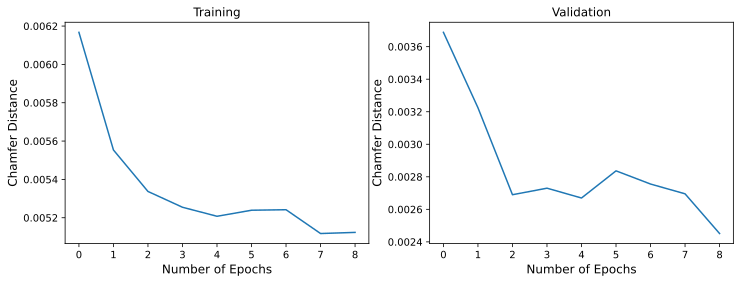

In [331]:
compare_train_val_losses(model_paths)

Note the analysis below is based on *my* models, but your models could certainly have different relative performances.

##### **Quick Analysis**
It's unsurprising that the best model **pc_denoiser_1** with parameters $\epsilon=0.01$ and $r=0$ reached the best performance. In fact, it converged relatively quickly, while the other models more or less plateaued. If we compare this model with **pc_denoiser_2** which has $r=0$, meaning point clouds were missing $50\%$ of their points about half the time, we see that the difference in performance can be attributed to the missing points. Indeed, it does seem like point cloud completion is a much harder task to solve, and may require longer training with more careful learning rate scheduling and hyperparameter tuning. Furthermore, this is corroborated by the fact that the second best performing model was **pc_denoiser_3** with $\epsilon=0.02$ and $r=0$, which seemed to still have significant room for performance, if I had extended the number of epochs to 200, for example.

### Testing PCDenoiser

#### **Evaluation Metrics**
Now, let's test these models on our hold-out augmented test set using the average Chamfer Distance over the entire set of point clouds as a final evaluation metric. As defined earlier during the training section, we can calculate this using the `get_baseline_chamfer_dist()`.

Next, I've defined a function for testing the models and saving the results to a CSV file using pandas.

In [111]:
def test_models(
    model_paths: List, save_path: str = "./test_results.csv"
) -> None:
    """Tests each provided model on test data and saves results."""
    df_col_labels = [
        "model",
        "noise_amount",
        "removal_ratio",
        "avg_chamf_dist",
        "avg_chamf_dist_baseline"
    ]
    df_rows = []
    # set validation seed for fixed data augmentations
    np.random.seed(1)

    for checkpoint_name in model_paths:
        # load checkpoint
        state_dict = torch.load(
            f=checkpoint_name, map_location=device
        )

        # create data transform
        input_transform = RandomTransform(
            removal_amount=state_dict["removal_amount"],
            noise_amount=state_dict["noise_amount"]
        )

        # load test data
        test_data = NoisyShapeNetCore(
            split="test",
            max_points=state_dict["max_points"],
            input_transform=input_transform
        )
        test_loader = DataLoader(
            dataset=test_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            worker_init_fn=worker_init_fn
        )

        # get baseline mean chamfer distance score
        baseline_score = get_baseline_chamfer_dist(test_loader, device=device)

        # instantiate model
        model = PCDenoiser(
            num_layers=state_dict["num_layers"],
            num_heads=state_dict["num_heads"],
            d_model=state_dict["d_model"]
        ).to(device)

        # necessary if distributed training was used
        if all(key.startswith("module.") for key in state_dict["model"].keys()):
            model = nn.DataParallel(model)

        # load weights
        model.load_state_dict(state_dict["model"])
        print(f"Testing model: {Path(checkpoint_name).stem}")
        test_loss = validate_epoch(
            model=model,
            dataloader=test_loader
        )
        avg_chamfer_dist = test_loss
        avg_baseline_score = baseline_score
        df_rows.append([
            Path(checkpoint_name).stem,
            state_dict["noise_amount"],
            state_dict["removal_amount"],
            avg_chamfer_dist,
            avg_baseline_score
        ])
        print(
            f"Average Chamfer Distance: {avg_chamfer_dist}, "
            f"Baseline: {avg_baseline_score}"
        )

    # create dataframe
    pd.DataFrame(df_rows, columns=df_col_labels).to_csv(save_path, index=False)

Run the following cell to test the models and display the test results:

In [112]:
# run testing
test_models(model_paths=model_paths)

<ipython-input-111-ae285eac1ca9>:18: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Testing model: pc_denoiser_1


valid:   0%|          | 1/360 [00:00<01:38,  3.63it/s, mean_loss=0.211]Exception ignored in: <function _after_at_fork_child_reinit_locks at 0x7acba2b3a560>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 254, in _after_at_fork_child_reinit_locks
    def _after_at_fork_child_reinit_locks():
KeyboardInterrupt: 
Exception ignored in: <function _after_fork at 0x7acba2cb9ab0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1636, in _after_fork
    thread._stop()
  File "/usr/lib/python3.10/threading.py", line 1050, in _stop
    if not self.daemon:
  File "/usr/lib/python3.10/threading.py", line 1183, in daemon
    @property
KeyboardInterrupt: 
valid:   1%|          | 4/360 [00:00<00:36,  9.63it/s, mean_loss=0.211]


KeyboardInterrupt: 

Let's take a look at the test scores as a table:

In [90]:
# display test results
results_df = pd.read_csv("./test_results.csv")
results_df

,model,noise_amount,removal_ratio,avg_chamf_dist,avg_chamf_dist_baseline
0,pc_denoiser_1,0.01,0,0.028788,0.014346


To understand whether our models perform better than baseline (without the use of a model), let's compare their average Chamfer Distances over the entire test set:

TypeError: object of type 'Axes' has no len()

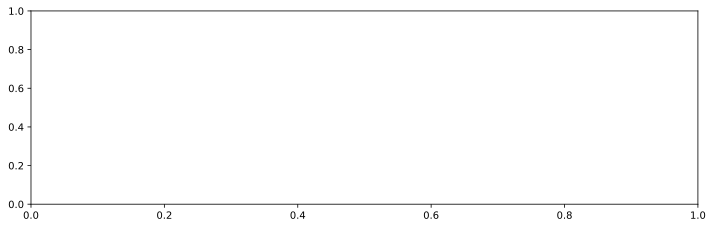

In [91]:
fig, ax = plt.subplots(1, len(results_df["model"]), figsize=(12, 3.5))
# create x labels
x = [""] * len(results_df["model"]) * 2
x[0::2] = results_df["model"]
x[1::2] = [f"baseline_{model_name.split('_')[-1]}" for model_name in results_df["model"]]

model_scores = results_df["avg_chamf_dist"]
baseline_scores = results_df["avg_chamf_dist_baseline"]

# create bar plot heights
heights = [0] * len(model_scores) * 2
heights[0::2] = model_scores
heights[1::2] = baseline_scores

for i in range(len(ax)):
    ax[i].bar(x=x[i * 2: (i + 1) * 2], height=heights[i * 2: (i + 1) * 2], width=0.7)
    ax[i].set_ylabel("Average Chamfer Distance")
plt.tight_layout()
    # ax[i].set_yscale("log")

We see that...

#### **Visualizing Point Cloud Reconstructions**
For this, let's just look at our top two models and how they reconstruct the noisy point clouds.

In [2]:
# get name of top two models
# top_two_models = results_df.iloc[results_df["avg_chamf_dist"].sort_values().index]["model"][:2].tolist()


# saved model paths
model_paths = list(Path.cwd().glob("pc_denoiser*.pth"))
# print saved model paths
print("Models saved to:")
for model_path in model_paths:
    print(model_path)
    
    
for checkpoint_name in model_paths:

    # skip poor performing models
    # if Path(checkpoint_name).stem not in top_two_models:
    #     continue

    # load checkpoint
    state_dict = torch.load(
        f=checkpoint_name, map_location=device
    )

    # create data transform
    input_transform = RandomTransform(
        removal_amount=state_dict["removal_amount"],
        noise_amount=state_dict["noise_amount"]
    )

    # load test data
    test_data = NoisyShapeNetCore(
        split="test",
        max_points=state_dict["max_points"],
        input_transform=input_transform
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    # instantiate model
    model = PCDenoiser(
        num_layers=state_dict["num_layers"],
        num_heads=state_dict["num_heads"],
        d_model=state_dict["d_model"]
    ).to(device)

    # necessary if distributed training was used
    if all(key.startswith("module.") for key in state_dict["model"].keys()):
        model = nn.DataParallel(model)

    # load weights
    model.load_state_dict(state_dict["model"])

    # visualize
    visualize_point_cloud_comparison(
        dataset=test_data,
        class_label="Airplane",
        model=model,
        title=Path(checkpoint_name).stem
    )
    time.sleep(0.2)

NameError: name 'Path' is not defined

# Task II: Defective Point Cloud Generation via Diffusion